# 17 Category Flower Dataset

Classification of the 17 Category Flower Dataset using a Convolutional Neural Network

The Dataset contains 17 different flower classes with 80 images for each class. The images have large scale, pose and light variations and there are also classes with large varations of images within the class and close similarity to other classes.

Dataset Source: https://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html


In [1]:
#Import the Necessary Packages
import tarfile
import urllib
import shutil
import os
import cv2

import math
import random

from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Set up GPU (If Available)

In [2]:
#Set the device as CUDA (GPU), if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device
print(device)

cuda:0


## Data Retrieval

In [3]:
# Data retrieval

url = "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/"

# Creates the work directory, downloads the 17flowers.tgz file and extracts the jpg images
def download_data(filename, source_url, work_directory):

    if not os.path.exists(work_directory): #check if the folder exists; if not make dir
      os.mkdir(work_directory)

    filepath = os.path.join(work_directory, filename)
    if not os.path.exists(filepath): # check if file exists; if not, download
      print("Downloading files, Please wait...")
      # this is a function to download files
      filepath, headers = urllib.request.urlretrieve(source_url + filename, filepath) 
      print("Download Complete")

    #Extracts the jpg image files
    print ("extracting flower images...")
    tar = tarfile.open(filepath)
    tar.extractall(path = work_directory)
    tar.close()
    print ("extract complete!")

download_data("17flowers.tgz", url, "17category-flowers-py")

Download Complete
extracting flower images...
extract complete!


In [4]:
# Get/Check current working directory for files
cwd = os.getcwd()
print(cwd)
os.listdir(cwd + "/17category-flowers-py/") # The jpg directory should be available

/kaggle/working


['jpg', '17flowers.tgz']

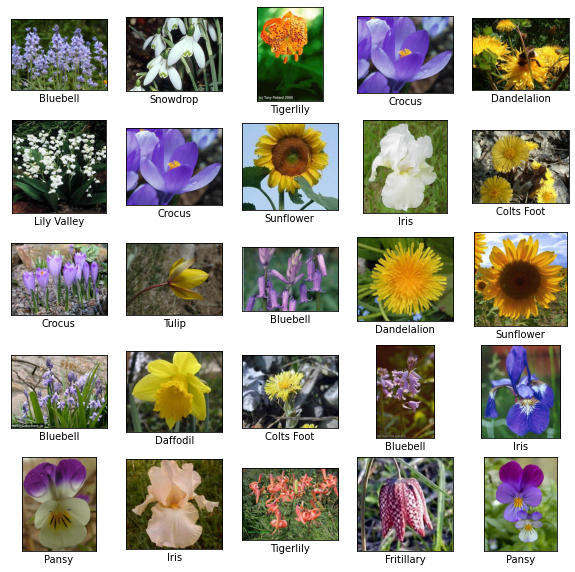

In [5]:
#Print Out several examples of images and their labels
#Gives us an idea of the variation in the images
classes = ['Daffodil','Snowdrop', 'Lily Valley', 'Bluebell',
           'Crocus', 'Iris', 'Tigerlily', 'Tulip',
           'Fritillary', 'Sunflower', 'Daisy', 'Colts Foot',
            'Dandelalion', 'Cowslip', 'Buttercup', 'Windflower',
            'Pansy']

plt.figure(figsize=(10,10)) # plot 25 images
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    random_image = str(random.randint(1,1360)).zfill(4)
    plt.imshow(Image.open(cwd + "/17category-flowers-py/jpg/image_" + random_image + ".jpg"), cmap=plt.cm.binary)
    image_class = math.floor(int(random_image)/80)
    plt.xlabel(classes[image_class])

Based on the above images, we can see that there is some variation in the images of one class (scale and pose) and that some classes (Dandelion and Colts Foot) have very similar features.

The images also come in a variety of sizes and will need to be consistently rescaled

## Prepare Data for Neural Network

This section loads the data (images and labels) into a numpy array, splits the data into training and testing sets, and stores the data into folders based on their class

In [6]:
# Load data into a numpy array
def load_data(fpath):    
    img=Image.open(fpath).resize((224,224)) # resize to 224x224 for training purposes
    img = np.asarray(img, dtype='float32')
    return img

images=[]
labels=[]
y=1
for i in range(1, 1361): 
    fname= cwd + "/17category-flowers-py/jpg/image_"  
    fpath = os.path.join(fname + str(i).zfill(4) + ".jpg")
    images.append(load_data(fpath))
    labels.append(y) #create all the labels as well
    if i%80==0: #Each class has 80 samples
      y+=1 

images = np.asarray(images) # all of the images are converted to np array of (1360,224,224,3)
labels = np.asarray(labels).reshape(1360,1) # labels are also converted to (1360,1)

print(images.shape)
print(labels) # The labels are lists within a list

(1360, 224, 224, 3)
[[ 1]
 [ 1]
 [ 1]
 ...
 [17]
 [17]
 [17]]


In [7]:
# split data into training and test
train_images, test_images, train_labels, test_labels = train_test_split(images,labels,train_size = 0.8,random_state = 100)

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)

(1088, 224, 224, 3)
(1088, 1)
(272, 224, 224, 3)


In [8]:
# Create Train/Test Folders
def create_data_folders(data, labels, folder_name):

  directory_name = cwd + "/17category-flowers-py/" + folder_name
  if not os.path.exists(directory_name):
    os.mkdir(directory_name)

  x = 0
  for i in data:
    label = labels[x][0] # accessing the first element in x list
    subfolder = directory_name + "/" + classes[label-1]
    if not os.path.exists(subfolder): # Create a subfolder for each class
      os.mkdir(subfolder)

    file_path =  subfolder + "/" + str(x) + ".jpg"
    #save image to corresponding subfolders and convert from BRG to RGB
    cv2.imwrite(file_path, cv2.cvtColor(data[x], cv2.COLOR_RGB2BGR)) 
    x+=1
  
#save image to corresponding subfolders
create_data_folders(train_images, train_labels, 'train') 
create_data_folders(test_images, test_labels, 'test')


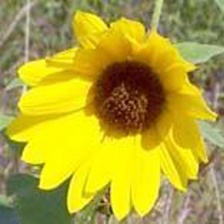

In [9]:
#Now the images are stored in their corresponding folders based on their class
Image.open(cwd + "/17category-flowers-py/train/Sunflower/1005.jpg")

## Define Data Transform and Create Data Loader

The Data Transform gets the data ready for use with Pytorch.

Dataloader is able to spit out random samples of our data, so our model won’t have to deal with the entire dataset every time. In general, this makes training more efficient.

In [10]:
# Data Transform
# Data transform converts the data to a Tensor
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#Random Data Augmentation (Use if you want to augment the data randomly for each epoch)
#This is done to reduce the chance of overfitting when training over multiple epochs
transformations_augment = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(255),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#ImageFolder provides images and corresponding labels. Also applies the transforms above
train_set = torchvision.datasets.ImageFolder(cwd + "/17category-flowers-py/train/", transform = transformations_augment)
test_set = torchvision.datasets.ImageFolder(cwd + "/17category-flowers-py/test/", transform = transformations)

# Load Data into a DataLoader (So we can use random batches of our data to train the model)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=5, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size =5, shuffle=True)


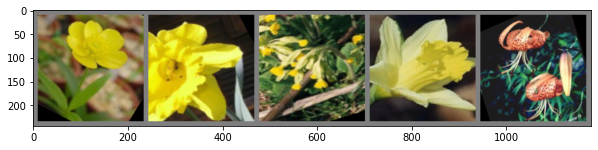

    Buttercup         Daffodil         Cowslip         Daffodil         Tigerlilly    


In [11]:
# Plot one batch of figures and labels (With the Random Augmentations)
classes_alpha = ['Bluebell', 'Buttercup', 'Colts Foot', 'Cowslip', 'Crocus',
                 'Daffodil', 'Daisy', 'Dandelion', 'Fritillary', 'Iris',
                 'Lily Valley', 'Pansy', 'Snowdrop', 'Sunflower', 'Tigerlilly',
                 'Tulip', 'Windflower']

#Defines a function to display the sample images
def imshow(img):
    plt.figure(figsize=(10,10))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()     # convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #transpose the numpy array to the correct dimensions and create an image using plt.show
    plt.show()              # Display Images

# get some random training images
# dataiter calls one iteration (One mini-batch) of samples from trainloader
dataiter = iter(train_loader)
images, labels = dataiter.next()

#print(images.size())
#print(labels)

# show images
imshow(torchvision.utils.make_grid(images, padding = 10))
# print labels
print(' '.join('    %5s    ' % classes_alpha[labels[j]] for j in range(5)))

## Define the CNN

The network has two convolutional layers (with max pooling) and three fully connected layers

In [12]:
#Use the nn.Module to define the Convolution Neural Network
#The Convolution Neural Network includes 2 convolution layers (with maxpool) and 3 linear fully connected layers
#Relu was used as the activation function
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()     #Inherits the attributes of the nn.Module class
        
        self.conv1 = nn.Conv2d(3, 32, 3)        #3 input image channel, 32 output channels, 3x3 square convolution
        self.pool = nn.MaxPool2d(2, 2)          #2*2 Max pooling with stride of 2
        self.conv2 = nn.Conv2d(32, 64, 3)       #32 input channel, 64 output channel, 3x3 square convolution
        self.fc1 = nn.Linear(64 * 54 * 54, 1024)   
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 17)

    def forward(self, x):
        #Runs the input data through the network layer by layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 54 * 54)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=186624, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=17, bias=True)
)


## Loss Function and Optimizer

In [13]:
#Use the nn Module to create a Cross Entropy Loss Function
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()

#Use the torch.optim package to set up the function that updates the weights (Stochastic Gradient Descent or Adams)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.001)

## Train the Network

For each epoch, the model is trained and then tested to see how the model performs over time

In [14]:
training_accuracy = []
testing_accuracy = []
train_loss = []
test_loss = []

for epoch in range(60):  # loop over the dataset multiple times (epochs)

    #Initialize these values as zero at the start of each epoch
    running_loss = 0.0
    test_running_loss = 0.0
    train_total = 0.0
    train_correct = 0.0 
    for i, data in enumerate(train_loader, 0):
        # iterates over training dataset (trainloader grabs min-batches of training data ; ex.5 images)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients (Otherwise gradients will be accumulated to exisitng gradients)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels) #Calculate the loss
        loss.backward()   #Computes the gradients
        optimizer.step()  #Updates the weights

        #Accuracy on training set
        _, predicted = torch.max(outputs.data, 1) #Maximum output value is the predicted
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()   # Add the loss to the running loss
        if i % 50 == 49:              # print every 50 mini-batches (epoch, number of mini-batches, and average loss)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/50))
            train_loss.append(running_loss/50)
            running_loss = 0.0        #Reset running loss back to 0 (allows tracking of improvement over time)

    #Print training results in % accuracy        
    print('[%d] Accuracy of the network on the 1088 training images: %d %%' % (
        epoch + 1, 100 * train_correct / train_total))

    training_accuracy.append(100*train_correct/train_total) 

    #Testing Accuracy as a function of epoch number    
    #initialize correct and total values as 0
    correct = 0
    total = 0

    # Since we don't want to update weights based on the test data we use the torch.no_grad for this process
    with torch.no_grad():
        for data in test_loader:
            #iterate through test data mini-batches 
            #(run data through network, use largest output number as prediction, and update total and correct values accordingly)
            images, labels = data[0].to(device), data[1].to(device)

            #Use the trained model to predict outputs
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels) #Calculate the loss
            test_running_loss += loss.item()  #Add loss to running loss

    #Print results in % accuracy        
    print('[%d] Accuracy of the network on the 272 test images: %d %%' % (
        epoch + 1, 100 * correct / total))
    
    testing_accuracy.append(100*correct/total)
    test_loss.append(test_running_loss/(272/5))
    
print('Finished Training')

[1,    50] loss: 2.828
[1,   100] loss: 2.789
[1,   150] loss: 2.720
[1,   200] loss: 2.456
[1] Accuracy of the network on the 1088 training images: 10 %
[1] Accuracy of the network on the 272 test images: 18 %
[2,    50] loss: 2.422
[2,   100] loss: 2.350
[2,   150] loss: 2.328
[2,   200] loss: 2.229
[2] Accuracy of the network on the 1088 training images: 18 %
[2] Accuracy of the network on the 272 test images: 23 %
[3,    50] loss: 2.209
[3,   100] loss: 2.132
[3,   150] loss: 2.121
[3,   200] loss: 2.046
[3] Accuracy of the network on the 1088 training images: 25 %
[3] Accuracy of the network on the 272 test images: 35 %
[4,    50] loss: 1.994
[4,   100] loss: 1.976
[4,   150] loss: 1.910
[4,   200] loss: 1.784
[4] Accuracy of the network on the 1088 training images: 31 %
[4] Accuracy of the network on the 272 test images: 41 %
[5,    50] loss: 1.788
[5,   100] loss: 1.801
[5,   150] loss: 1.854
[5,   200] loss: 1.728
[5] Accuracy of the network on the 1088 training images: 38 %
[5

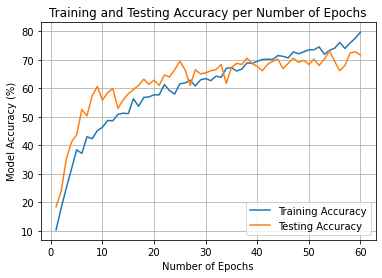

In [15]:
#Plot the training and testing accuracy as a function of training epochs
epochs = np.linspace(1,60,60) #Number of Epochs

plt.plot(epochs, training_accuracy, label = "Training Accuracy")
plt.plot(epochs, testing_accuracy, label = "Testing Accuracy")
plt.title("Training and Testing Accuracy per Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Model Accuracy (%)")
plt.legend(loc="lower right")
plt.grid(True)

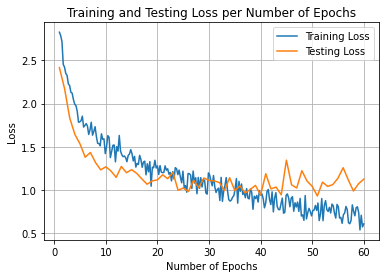

In [16]:
#Plot of the Training and Testing Loss
epochs_alt = np.linspace(1,60,240) # Total divided by minibatch

plt.plot(epochs_alt, train_loss, label = "Training Loss")
plt.plot(epochs, test_loss, label = "Testing Loss")
plt.title("Training and Testing Loss per Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)

Without the data augmentation we were seeing a lot of overfitting starting after 5 epochs. The testing accuracy maxed out around 60% while the training accuracy went up to 100%. This means that the model wouldn't of generalized well.


With data augmentaion (seen above) the model does much better with regards to overfitting. The training and testing accuracy are very similar. The testing accuracy is also better getting above 70% testing accuracy.

## Test Network on Subset of Data

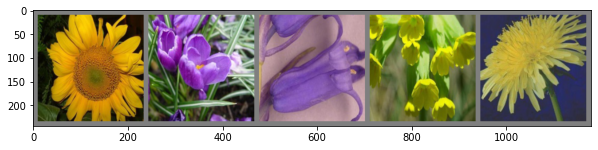

GroundTruth: 
    Sunflower        Crocus        Bluebell        Cowslip        Dandelion   


In [17]:
# In order to test if the Network has learned anything, it'll be tested on a small sample of test data
# dataiter calls one iteration (One mini-batch) of samples from testloader
dataiter = iter(test_loader)
data = dataiter.next()
images, labels = data

# print images with the same imshow function defined earlier along with their true labels
imshow(torchvision.utils.make_grid(images, padding = 10))
print('GroundTruth: ')
print(' '.join('    %5s   ' % classes_alpha[labels[j]] for j in range(5)))

In [18]:
# Run the test images displayed through the network to determine if they are classified correctly
images, labels = data[0].to(device), data[1].to(device)
outputs = net(images)

#Essentially takes the highest number at the output as the estimated classification
_, predicted = torch.max(outputs, 1)

#print results
print('Predicted: ')
print(' '.join('    %5s   ' % classes_alpha[labels[j]] for j in range(5)))

Predicted: 
    Sunflower        Crocus        Bluebell        Cowslip        Dandelion   


## Test Network on Full Test Set

Full test set of 272 samples

In [19]:
#initialize correct and total values as 0
correct = 0
total = 0

# Since we don't want to update weights based on the test data we use the torch.no_grad for this process
with torch.no_grad():
    for data in test_loader:
        #iterate through test data mini-batches 
        #(run data through network, use largest output number as prediction, and update total and correct values accordingly)
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

#Print results in % accuracy        
print('Accuracy of the network on the 272 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 272 test images: 71 %


## Look at the Accuracy of Individual Classes

Overall the model performed much better than random guess. However, there are certain classes that are likely to have poor results due to similar features. Looking at the accuracy per class we can gain insight into the problem areas of the model

In [20]:
#Initialize the class_correct and class_total values as zero for all classes
class_correct = list(0. for i in range(17))
class_total = list(0. for i in range(17))

# Since we don't want to update weights based on the test data we use the torch.no_grad for this process
with torch.no_grad():
    for i, data in enumerate(test_loader):
        #iterate through test data mini-batches 
        #(run data through network, use largest output number as prediction)
        #images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        #print(labels)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()    #If the predicted equals the true label, c will be 1 for that data point 
        #print(c)

        #print(i)
        if i == 54:
          for j in range(2):
            #Update the label item class_correct and class_total values accordingly (If it was predicted corectly or not)
            label = labels[j]
            class_correct[label] += c[j].item()
            class_total[label] += 1
        else:
          for j in range(5):
            #Update the label item class_correct and class_total values accordingly (If it was predicted corectly or not)
            label = labels[j]
            class_correct[label] += c[j].item()
            class_total[label] += 1

#Print out the results for each class correct/total
for i in range(17):
    print('Accuracy of %5s : %2d %%' % (
        classes_alpha[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Bluebell : 89 %
Accuracy of Buttercup : 55 %
Accuracy of Colts Foot : 84 %
Accuracy of Cowslip : 71 %
Accuracy of Crocus : 57 %
Accuracy of Daffodil : 58 %
Accuracy of Daisy : 84 %
Accuracy of Dandelion : 69 %
Accuracy of Fritillary : 90 %
Accuracy of  Iris : 76 %
Accuracy of Lily Valley : 63 %
Accuracy of Pansy : 76 %
Accuracy of Snowdrop : 76 %
Accuracy of Sunflower : 100 %
Accuracy of Tigerlilly : 86 %
Accuracy of Tulip : 38 %
Accuracy of Windflower : 38 %


As expected, there is quite a bit of variation with the accuracies of individual classes. Some of the classes performed much better than others. The poor performance of some classes is likely due to similar features leading to one class to classified as another class

## Alternative Strategy

The previous model performed well but a problem is that there wasn't very much data to train the CNN. A limited amount of data can lead to poor results as there is only so much augmentating the data can achive.

An alternative strategy is to use a pretrained model for the Convolutional  and then tailor it to our specific problem. This process is called transfered learning.

Image recognition models have two parts:
1. the convolutional part and
2. the classifier part

We want to keep the pre-trained convolutional part but put in our own classifier. These pre-trained convolutional layers were trained to identify features very well, regardless of what kind of image you have. We then replace the pre-trained classifier part with our own and train it with our data.

In [21]:
# Data transform converts the data to a Tensor
# We are also using the normalization specified by the pretrained model we are going to use
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Random Data Augmentation (Use if you want to augment the data randomly for each epoch)
#This is done to reduce the chance of overfitting when training over multiple epochs
transformations_augment = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(255),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#ImageFolder provides images and corresponding labels. Also applies the transforms above
train_set = torchvision.datasets.ImageFolder(cwd + "/17category-flowers-py/train/", transform = transformations_augment)
test_set = torchvision.datasets.ImageFolder(cwd + "/17category-flowers-py/test/", transform = transformations)

# Load Data into a DataLoader (So we can use random batches of our data to train the model)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=5, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size =5, shuffle=True)

In [22]:
# Get pretrained model using torchvision.models as models library (specify that it is pretrained)
# There are many choices for pretrained models. 
# densenet161 is a Denesly Connected Convolutional Network that has achieved high accuracy on image datasets
model = models.densenet161(pretrained=True)

# Turn off training for their parameters
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [23]:
# Create new classifier for model using torch.nn as nn library
classifier_input = model.classifier.in_features

classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, 17),
                           nn.LogSoftmax(dim=1))

# Replace default classifier with new classifier
model.classifier = classifier

In [24]:
# Move model to the device
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [25]:
# Set the error function using torch.nn as nn library
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()

# Set the optimizer function using torch.optim as optim library
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.classifier.parameters())

In [26]:
training_accuracy = []
testing_accuracy = []
training_loss = []
testing_loss = []

for epoch in range(25): # loop over the dataset multiple times (epochs)

    #Initialize these values as zero at the start of each epoch
    train_running_loss = 0
    train_loss = 0
    test_running_loss = 0
    test_loss = 0
    train_accuracy = 0
    test_accuracy = 0
    
    # Training the model (need to specify for this pretrained model)
    model.train()

    for i, data in enumerate(train_loader,0):
        # Move Data to device
        inputs, labels = data[0].to(device), data[1].to(device)

        # Clear optimizers
        optimizer.zero_grad()

        # Forward pass
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels) #Calculate Loss
        loss.backward()  # Calculate gradients (backpropogation)
        optimizer.step()  # Adjust parameters based on gradients

        # Add the loss to the training set's running loss
        train_running_loss += loss.item()*inputs.size(0)
        
        # Since our model outputs a LogSoftmax, find the real 
        # percentages by reversing the log function
        outputs = torch.exp(outputs)
        # Get the top class of the output
        top_p, top_class = outputs.topk(1, dim=1)
        # See how many of the classes were correct?
        equals = top_class == labels.view(*top_class.shape)
        # Calculate the mean (get the accuracy for this batch)
        # and add it to the running accuracy for this epoch
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    # Evaluating the model (need to specify for this pretrained model)
    model.eval()

    # Tell torch not to calculate gradients
    with torch.no_grad():
        for data in test_loader:
            # Move Data to device
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model.forward(inputs)
            t_loss = criterion(outputs, labels) #Calculate testing Loss

            # Add loss to the testing set's running loss
            test_running_loss += t_loss.item()*inputs.size(0)
            
            # Since our model outputs a LogSoftmax, find the real percentages by reversing the log function
            outputs = torch.exp(outputs)
            # Get the top class of the output
            top_pct, top_class = outputs.topk(1, dim=1)
            # See how many of the classes were correct?
            equals = top_class == labels.view(*top_class.shape)
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
    # Get the average loss for the entire epoch
    train_loss = train_running_loss/len(train_loader.dataset)
    test_loss = test_running_loss/len(test_loader.dataset)

    # Print out the information
    print('Epoch: {} \tTraining Loss: {:.6f} \tTesting Loss: {:.6f}'.format(epoch, train_loss, test_loss))
    print('Training Accuracy: ', round(train_accuracy/len(train_loader)*100,2), '%')
    print('Testing Accuracy: ', round(test_accuracy/len(test_loader)*100,2), '%')

    #Save the Accuracy and Loss for Plotting
    training_accuracy.append(round(train_accuracy/len(train_loader)*100,2))
    testing_accuracy.append(round(test_accuracy/len(test_loader)*100,2))

    training_loss.append(train_loss)
    testing_loss.append(test_loss)

print('Finished Training')


Epoch: 0 	Training Loss: 2.793567 	Testing Loss: 2.699343
Training Accuracy:  11.56 %
Testing Accuracy:  25.64 %
Epoch: 1 	Training Loss: 2.592896 	Testing Loss: 2.251445
Training Accuracy:  31.01 %
Testing Accuracy:  53.45 %
Epoch: 2 	Training Loss: 2.159049 	Testing Loss: 1.492345
Training Accuracy:  41.41 %
Testing Accuracy:  69.09 %
Epoch: 3 	Training Loss: 1.577596 	Testing Loss: 0.889095
Training Accuracy:  54.74 %
Testing Accuracy:  79.45 %
Epoch: 4 	Training Loss: 1.256605 	Testing Loss: 0.601279
Training Accuracy:  63.73 %
Testing Accuracy:  86.73 %
Epoch: 5 	Training Loss: 1.062444 	Testing Loss: 0.567467
Training Accuracy:  69.6 %
Testing Accuracy:  81.82 %
Epoch: 6 	Training Loss: 0.963517 	Testing Loss: 0.402894
Training Accuracy:  70.55 %
Testing Accuracy:  89.45 %
Epoch: 7 	Training Loss: 0.811879 	Testing Loss: 0.369883
Training Accuracy:  76.02 %
Testing Accuracy:  91.64 %
Epoch: 8 	Training Loss: 0.730823 	Testing Loss: 0.298384
Training Accuracy:  77.52 %
Testing Acc

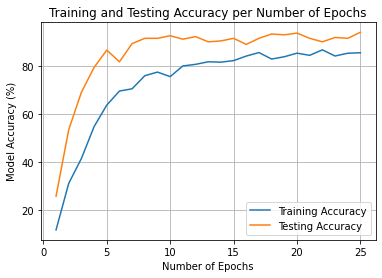

In [27]:
#Plot the training and testing accuracy as a function of training epochs
epochs = np.linspace(1,25,25) #Number of Epochs

plt.plot(epochs, training_accuracy, label = "Training Accuracy")
plt.plot(epochs, testing_accuracy, label = "Testing Accuracy")
plt.title("Training and Testing Accuracy per Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Model Accuracy (%)")
plt.legend(loc="lower right")
plt.grid(True)

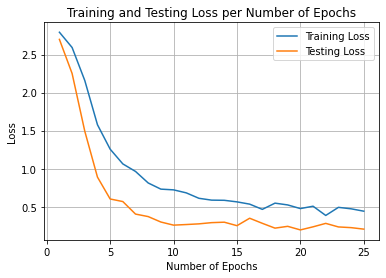

In [28]:
#Plot of the Training and Testing Loss

plt.plot(epochs, training_loss, label = "Training Loss")
plt.plot(epochs, testing_loss, label = "Testing Loss")
plt.title("Training and Testing Loss per Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)


## Test Network on Subset of Data

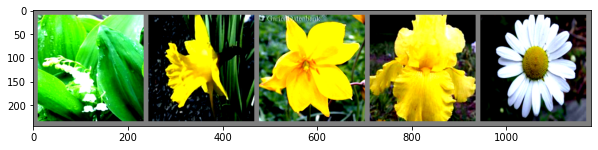

GroundTruth: 
    Lily Valley        Daffodil        Tulip         Iris        Daisy   


In [29]:
# In order to test if the Network has learned anything, it'll be tested on a small sample of test data
# dataiter calls one iteration (One mini-batch) of samples from testloader
dataiter = iter(test_loader)
data = dataiter.next()
images, labels = data

# print images with the same imshow function defined earlier along with their true labels
imshow(torchvision.utils.make_grid(images, padding = 10))
print('GroundTruth: ')
print(' '.join('    %5s   ' % classes_alpha[labels[j]] for j in range(5)))

In [30]:
# Run the test images displayed through the network to determine if they are classified correctly
images, labels = data[0].to(device), data[1].to(device)

outputs = model.forward(images)

# Since our model outputs a LogSoftmax, find the real Percentages by reversing the log function
outputs = torch.exp(outputs)
# Get the top class of the output
top_pct, top_class = outputs.topk(1, dim=1)

#print results
print('Predicted: ')
print(' '.join('    %5s   ' % classes_alpha[labels[j]] for j in range(5)))

Predicted: 
    Lily Valley        Daffodil        Tulip         Iris        Daisy   


## Test Network on Full Set

Test on all 272 images

In [31]:
#initialize correct and total values as 0
correct = 0
total = 0

# Since we don't want to update weights based on the test data we use the torch.no_grad for this process
with torch.no_grad():
    for data in test_loader:
        #iterate through test data mini-batches 
        #(run data through network, use largest output number as prediction, and update total and correct values accordingly)
        images, labels = data[0].to(device), data[1].to(device)

        # Forward pass
        outputs = model(images)
        # Since our model outputs a LogSoftmax, find the real percentages by reversing the log function
        outputs = torch.exp(outputs)
        # Get the top class of the output
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()    #If the predicted equals the true label, c will be 1 for that data point
        #print(c)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

#Print results in % accuracy        
print('Accuracy of the network on the 272 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 272 test images: 94 %


## Look at the Accuracy of Individual Classes

Overall the model performed much better than random guess. However, there are certain classes that are likely to have poor results due to similar features. Looking at the accuracy per class we can gain insight into the problem areas of the model

In [32]:
#Initialize the class_correct and class_total values as zero for all classes
class_correct = list(0. for i in range(17))
class_total = list(0. for i in range(17))

# Since we don't want to update weights based on the test data we use the torch.no_grad for this process
with torch.no_grad():
    for i, data in enumerate(test_loader):
        #iterate through test data mini-batches 
        #(run data through network, use largest output number as prediction)
        
        images, labels = data[0].to(device), data[1].to(device)
        #print(labels)
        #outputs = model.forward(images)
        outputs = model(images)
        # Since our model outputs a LogSoftmax, find the real 
        # percentages by reversing the log function
        outputs = torch.exp(outputs)

        # Get the predicted class of the output
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()    #If the predicted equals the true label, c will be 1 for that data point

        #print(i)
        if i == 54:
          for j in range(2):
            #Update the label item class_correct and class_total values accordingly (If it was predicted corectly or not)
            label = labels[j]
            class_correct[label] += c[j].item()
            class_total[label] += 1
        else:
          for j in range(5):
            #Update the label item class_correct and class_total values accordingly (If it was predicted corectly or not)
            label = labels[j]
            class_correct[label] += c[j].item()
            class_total[label] += 1

#Print out the results for each class correct/total
for i in range(17):
    print('Accuracy of %5s : %2d %%' % (
        classes_alpha[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Bluebell : 73 %
Accuracy of Buttercup : 88 %
Accuracy of Colts Foot : 100 %
Accuracy of Cowslip : 78 %
Accuracy of Crocus : 100 %
Accuracy of Daffodil : 91 %
Accuracy of Daisy : 100 %
Accuracy of Dandelion : 84 %
Accuracy of Fritillary : 95 %
Accuracy of  Iris : 92 %
Accuracy of Lily Valley : 100 %
Accuracy of Pansy : 100 %
Accuracy of Snowdrop : 100 %
Accuracy of Sunflower : 100 %
Accuracy of Tigerlilly : 95 %
Accuracy of Tulip : 100 %
Accuracy of Windflower : 94 %


Overall, the pretrained model performed much better than training the model on the limited amount of data. The pretrained model achieved an average testing accuracy above 90% with many classes having a 100% accuracy.